<a href="https://colab.research.google.com/github/Hrithik2212/Neural-Machine-Translation--English-to-Tamil/blob/main/03_NMT_with_Attention_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
#Libraries
import pathlib
import random
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
eng_file = '/content/drive/MyDrive/en-ta/train.en'
tamil_file = '/content/drive/MyDrive/en-ta/train.ta'

In [3]:
with open(eng_file, 'r') as file:
    english_sentences = file.readlines()
with open(tamil_file, 'r') as file:
    tamil_sentences = file.readlines()


english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
tamil_sentences = [sentence.rstrip('\n') for sentence in tamil_sentences]

In [5]:
# filter out sentences which contains letters other than whats listed below
tamil_vocabulary = [ ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ˌ',
                      "ஃ", "அ", "ஆ", "இ", "ஈ", "உ", "ஊ", "எ", "ஏ", "ஐ", "ஒ", "ஓ", "ஔ",
                      "க", "ங", "ச", "ஜ", "ஞ", "ட", "ண",
                      "த", "ந", "ன", "ப", "ம", "ய", "ர",
                      "ற", "ல", "ள", "ழ", "வ", "ஶ", "ஷ", "ஸ", "ஹ",
                      "ா", "ி", "ீ", "ு", "ூ", "ெ", "ே", "ை", "ொ", "ோ", "ௌ", "்", "ௗ",
                      "௦", "௧", "௨", "௫", "௬", "௲", "௳"
                      ]

english_vocabulary = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~']

In [6]:
def is_valid_tokens(sentence , vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

valid_sentence_indicies = []
for index in range(len(english_sentences[:400000])):
    tamil_sentence, english_sentence = tamil_sentences[index], english_sentences[index]
    if is_valid_tokens(tamil_sentence, tamil_vocabulary) \
      and is_valid_tokens(english_sentence , english_vocabulary):
        valid_sentence_indicies.append(index)

In [7]:
TOTAL_SENTENCES = 200000 # lets take 200000 valid sentences to train the model
x = [english_sentences[i] for i in valid_sentence_indicies[:TOTAL_SENTENCES]]
y = [tamil_sentences[i] for i in valid_sentence_indicies[:TOTAL_SENTENCES]]

In [8]:
import pandas as pd
dataset =  pd.DataFrame({"English":x , "Tamil":y })
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   English  200000 non-null  object
 1   Tamil    200000 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [9]:
dataset.sample(5)

,English,Tamil
113065,"college boys hostel, thiruvarur","கல்லூரி மாணவியர் விடுதி, திருவாரூர்"
78076,all the passengers were evacuated safe without...,"இதனால், பயணிகள் அனைவரும் எந்த வித காயமும் இன்ற..."
47910,that is how everybody is.,அதான் எல்லோரும் ஒதுங்கிட்டாங்க.
96308,25 lakh pricing.,25 லட்சம் மதிப்பீட்டில் மேற்கொள்ளப்படுகிறது.
73508,not deserved.,தகுதியில்லாமல் வரவில்லை.


In [10]:
text_pairs = []

for i in range(dataset.shape[0]) :
    eng = str(dataset["English"][i])
    tam = "[start] " + str(dataset["Tamil"][i]) + " [end]"
    text_pairs.append((eng,tam))

In [11]:
len(text_pairs)


200000

In [14]:
random.shuffle(text_pairs) #Shuffle the pairs
train_sample_size = len(text_pairs) - int(0.1*len(text_pairs))
train_pairs = text_pairs[:train_sample_size]
test_pairs = text_pairs[train_sample_size:]

In [15]:
print("Total pairs :", len(text_pairs))
print("Train pairs :", len(train_pairs))
print("Test pairs :", len(test_pairs))

Total pairs : 200000
Train pairs : 180000
Test pairs : 20000


In [16]:
strip_chars = string.punctuation + "|"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace('""', "")

vocab_size = 50000
sequence_length = 30
batch_size = 64

In [17]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [18]:
eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)

tam_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

In [19]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_tam_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
tam_vectorization.adapt(train_tam_texts)

In [20]:
def format_dataset(eng, tam):
    eng = eng_vectorization(eng)
    tam = tam_vectorization(tam)
    return ({"encoder_inputs": eng, "decoder_inputs": tam[:, :-1],}, tam[:, 1:])

In [21]:
def make_dataset(pairs):
    eng_texts, tam_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    tam_texts = list(tam_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, tam_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

In [22]:
train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [23]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 30)
inputs["decoder_inputs"].shape: (64, 30)
targets.shape: (64, 30)


In [24]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [25]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [26]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [27]:
embed_dim = 512
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

In [28]:
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

In [29]:
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)


In [31]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


In [30]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding (Posi  (None, None, 512)            2561536   ['encoder_inputs[0][0]']      
 tionalEmbedding)                                         0                                       
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                      

In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [34]:
learning_rate = CustomSchedule(latent_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

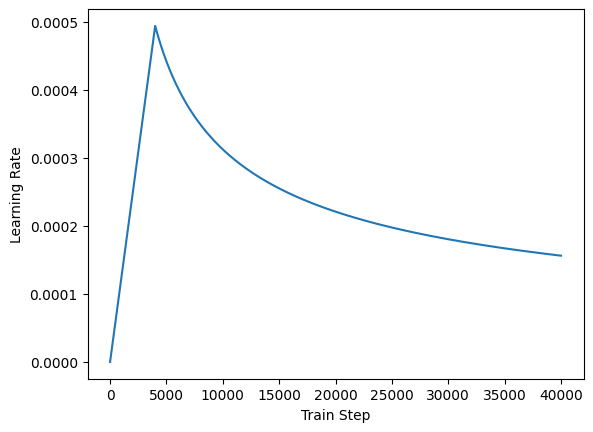

In [37]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [38]:
epochs = 30
transformer.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history = transformer.fit(train_ds,
                epochs=epochs,
                validation_data=test_ds ,
                callbacks=[early_stopping] )

Epoch 1/30
2813/2813 [==============================] - 891s 311ms/step - loss: 6.9836 - accuracy: 0.2673 - val_loss: 6.0672 - val_accuracy: 0.3069
Epoch 2/30
2813/2813 [==============================] - 899s 320ms/step - loss: 6.3184 - accuracy: 0.2964 - val_loss: 5.7916 - val_accuracy: 0.3211
Epoch 3/30
2813/2813 [==============================] - 864s 307ms/step - loss: 6.0416 - accuracy: 0.3102 - val_loss: 5.5966 - val_accuracy: 0.3324
Epoch 4/30
2813/2813 [==============================] - 862s 306ms/step - loss: 5.8891 - accuracy: 0.3181 - val_loss: 5.5230 - val_accuracy: 0.3399
Epoch 5/30
2813/2813 [==============================] - 862s 307ms/step - loss: 5.7789 - accuracy: 0.3240 - val_loss: 5.4513 - val_accuracy: 0.3423
Epoch 6/30
2813/2813 [==============================] - 864s 307ms/step - loss: 5.6975 - accuracy: 0.3291 - val_loss: 5.3989 - val_accuracy: 0.3457
Epoch 7/30
2813/2813 [==============================] - 863s 307ms/step - loss: 5.6214 - accuracy: 0.3336 - val_

In [ ]:
tam_vocab = tam_vectorization.get_vocabulary()
tam_index_lookup = dict(zip(range(len(tam_vocab)), tam_vocab))
max_decoded_sentence_length = 20

In [ ]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = tam_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = tam_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [ ]:
test_eng_texts = ""
input_sentence = ""
translated = decode_sequence(input_sentence)
print('English -' , input_sentence )
print('Tamil -' , translated)

English - you
Tamil - [start] [UNK] [end]


In [ ]:

test_eng_texts = [pair[0] for pair in train_pairs]
input_sentence = random.choice(test_eng_texts)
translated = decode_sequence(input_sentence)

In [ ]:
print('English -' , input_sentence )
print('Tamil -' , translated)

English - 50 lakh has been spent in
Tamil - [start] 50 லட்சம் வரை [UNK] [end]


In [ ]:
!mkdir /content/drive/MyDrive/English-Tamil-Translation-Models

In [ ]:
transformer.save('/content/drive/MyDrive/English-Tamil-Translation-Models/v0-50k-45M.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
